# Test Spark Delta Lake vs Parquet

# Init application

In [1]:
# {INIT_CODE-START}
# Set the job name
import os, sys
try: os.environ["JOB_NAME"]
except: os.environ["JOB_NAME"] = "TestSparkDeltaLakeVsParquet"
JOB_NAME = os.getenv("JOB_NAME")
# Set the home directories
HOME = os.getenv("HOME")
APPLICATION_HOME = os.getenv("APPLICATION_HOME")
if (APPLICATION_HOME == None): # Home detection
    APPLICATION_HOME = os.path.abspath(os.getcwd())
    for i in range(0, 10): # Start home detection
        if (os.path.isdir(APPLICATION_HOME + "/bin") and os.path.exists(APPLICATION_HOME + "/bin")): break
        else: APPLICATION_HOME += "/.."
    if (not os.path.exists(APPLICATION_HOME + "/bin") or not os.path.isdir(APPLICATION_HOME + "/bin")):
        print("APPLICATION_HOME not found !") ; sys.exit()
    APPLICATION_HOME = os.path.realpath(APPLICATION_HOME)
    os.environ["APPLICATION_HOME"] = APPLICATION_HOME
sys.path.append(APPLICATION_HOME + "/lib/init")
# Init env
from AppEnv_V1_3 import AppEnv
appEnv = AppEnv(APPLICATION_HOME)
# Init spark
try: spark
except: spark = None
sc, spark = appEnv.initSpark(spark)
# Set JupyterLab options if enabled
appEnv.setJupyterLabOptions()
# Set objects used by the developer
cfgSys = appEnv.cfgSys ; cfgProps = appEnv.cfgProps ; cfgYaml = appEnv.cfgYaml
log = appEnv.log ; sdu = appEnv.sdu ; sdlu = appEnv.sdlu
smu = appEnv.smu ; sthc = appEnv.sthc ; sths = appEnv.sths
txtu = appEnv.txtu ; ftpu = appEnv.ftpu ; smtp = appEnv.smtp
tika = appEnv.tika ; kfr = appEnv.kfr ; jsu = appEnv.jsu
# {INIT_CODE-END}

> Init

 - JOB_NAME="TestSparkDeltaLakeVsParquet"
 - Home directory: "/home/cnh/consumer-cnh-tigr-new"
 - Lib directory: "/home/cnh/consumer-cnh-tigr-new/lib"
 - Conf directory: "/home/cnh/consumer-cnh-tigr-new/conf"

 - Config file "env.conf" loaded.
 - Config file "spark.conf" loaded.
 - Config file "start.conf" loaded.
 - Config file "application.yaml" loaded.
 - Spark version: 3.0.1
 - Spark master: local[*]
 - Spark WebUI URL: http://ns3141360.ip-51-77-246.eu:4045


In [2]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [3]:
def benchWrite(df, X, partitions, outParquetDir, outDeltaDir):
    Y = []
    for x in X:
        l = []
        print(x)
        if (x>0):
            for n in range(10):

                # Save as Delta
                startTime = appEnv.getCurrentDatetime()
                sdlu.saveDfAsDelta(df=df, directory=outDeltaDir, compression=True, overwrite=True, cleanDirectory=True, partitionNames=partitions, nbrPartitions=x)
                endTime = appEnv.getCurrentDatetime()
                t1 = endTime - startTime

                # Save as Parquet
                startTime = appEnv.getCurrentDatetime()
                sdu.saveAsParquet(df=df, filePath=outParquetDir, compression=True, overwrite=True, partitionNames=partitions, nbrPartitions=x)
                endTime = appEnv.getCurrentDatetime()
                t2 = endTime - startTime

                p = 100 * (1 - t2/t1)
                l.append(p)

                print(f"{p}%")
        else:
            l.append(0)
        m = round(np.mean(l), 2)        
        Y.append(m)
        print(l)
        print(m)
        print()
    return Y

In [8]:
inParquetDir = APPLICATION_HOME + "/demo/data/bank-back.parquet"
df = sdu.loadParquet(inputDir=inParquetDir)
df.count()

4521

In [ ]:
X = [0, 1, 8, 16, 32, 48, 64, 80, 96, 128, 256, 512]
partitions = ["YEAR", "MONTH"]
outParquetDir = APPLICATION_HOME + "/demo/data/outBank.parquet"
outDeltaDir = APPLICATION_HOME + "/demo/data/outBank.delta"
Y = benchWrite(df, X, partitions, outParquetDir, outDeltaDir)

In [ ]:
print(Y)

## Bench read test with Delta format

In [169]:
startTime = appEnv.getCurrentDatetime()
df = sdlu.loadDeltaDf(outDeltaDir)
print(df.count())
df = df.where("AGE > 33 AND AGE < 50")
df.count()
df = df.where("YEAR=2020 AND (MONTH=12 OR MONTH=6 OR MONTH=7) AND AGE = 40")
df.count()
endTime = appEnv.getCurrentDatetime()
t = endTime - startTime
print(t)
df.unpersist();

4521
0:00:02.255176


## Bench read test with Parquet format

In [170]:
startTime = appEnv.getCurrentDatetime()
df = sdu.loadParquet(outParquetDir)
print(df.count())
df = df.where("AGE > 33 AND AGE < 50")
df.count()
df = df.where("YEAR=2020 AND (MONTH=12 OR MONTH=6 OR MONTH=7) AND AGE = 40")
df.count()
endTime = appEnv.getCurrentDatetime()
t = endTime - startTime
print(t)
df.unpersist();

4521
0:00:01.859140


## Bench write test with no folder partition

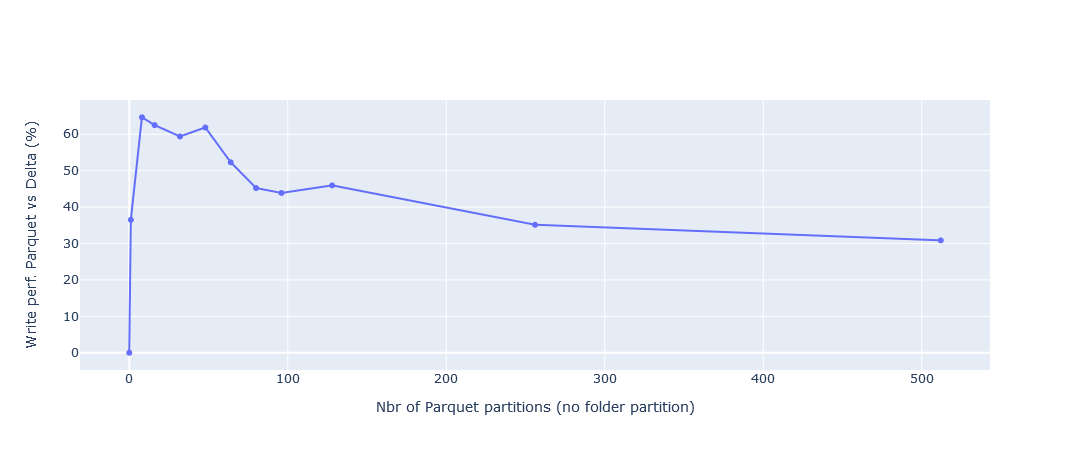

In [70]:
X = [0, 1, 8, 16, 32, 48, 64, 80, 96, 128, 256, 512]
Y = [0, 36.52, 64.68, 62.53, 59.4, 61.88, 52.32, 45.24, 43.89, 45.97, 35.16, 30.87]
fig = go.Figure(data=go.Scatter(x=X, y=Y))
fig.update_xaxes(title_text="Nbr of Parquet partitions (no folder partition)")
fig.update_yaxes(title_text="Write perf. Parquet vs Delta (%)")
fig.show()

## Bench write test with folder partition YEAR=y

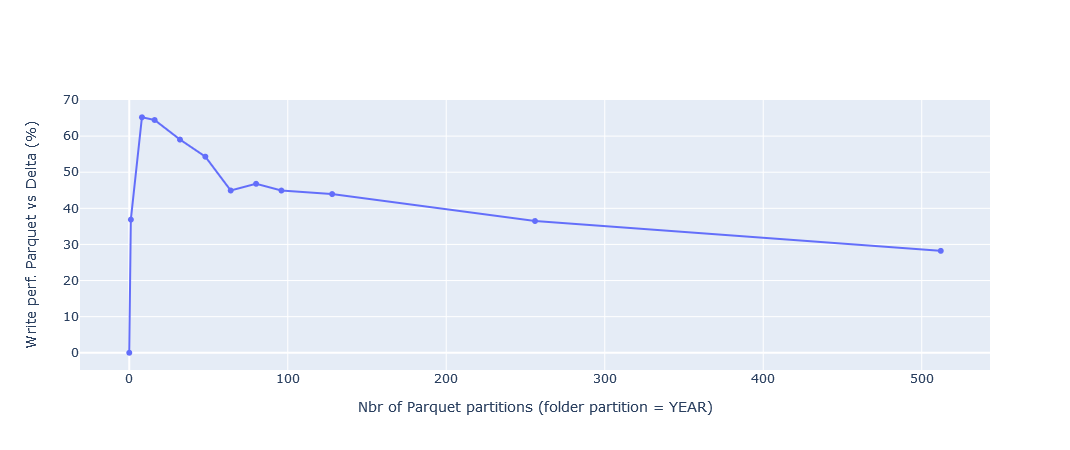

In [69]:
X = [0, 1, 8, 16, 32, 48, 64, 80, 96, 128, 256, 512]
Y = [0, 36.88, 65.22, 64.46, 59.05, 54.31, 44.94, 46.8, 44.93, 43.95, 36.49, 28.23]
fig = go.Figure(data=go.Scatter(x=X, y=Y))
fig.update_xaxes(title_text="Nbr of Parquet partitions (folder partition = YEAR)")
fig.update_yaxes(title_text="Write perf. Parquet vs Delta (%)")
fig.show()

## Bench write test with folder partitions YEAR=y/MONTH=m

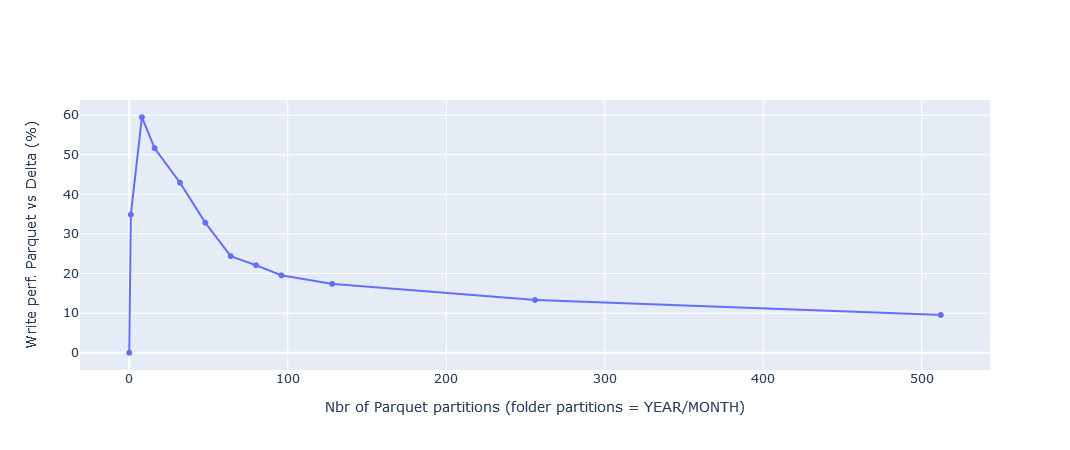

In [78]:
X = [0, 1, 8, 16, 32, 48, 64, 80, 96, 128, 256, 512]
Y = [0.0, 34.89, 59.45, 51.64, 42.94, 32.83, 24.38, 22.09, 19.54, 17.39, 13.33, 9.55]
fig = go.Figure(data=go.Scatter(x=X, y=Y))
fig.update_xaxes(title_text="Nbr of Parquet partitions (folder partitions = YEAR/MONTH)")
fig.update_yaxes(title_text="Write perf. Parquet vs Delta (%)")
fig.show()

## Bench write test with folder partitions YEAR=y/MONTH=m/DAY=d

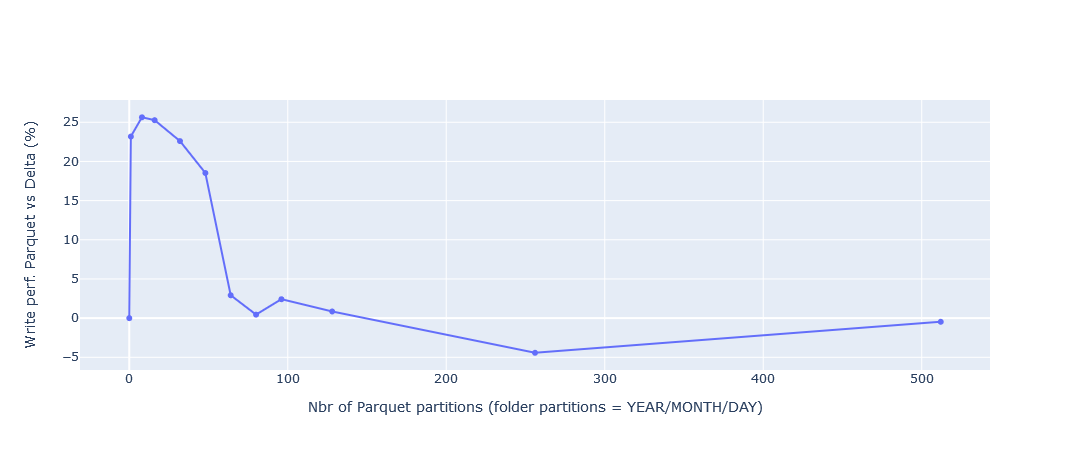

In [73]:
X = [0, 1, 8, 16, 32, 48, 64, 80, 96, 128, 256, 512]
Y = [0, 23.18, 25.64, 25.27, 22.6, 18.53, 2.92, 0.45, 2.42, 0.85, -4.42, -0.46]
fig = go.Figure(data=go.Scatter(x=X, y=Y))
fig.update_xaxes(title_text="Nbr of Parquet partitions (folder partitions = YEAR/MONTH/DAY)")
fig.update_yaxes(title_text="Write perf. Parquet vs Delta (%)")
fig.show()